# <span style='color:black'> Demo: Pulse-efficient Transpiler Pass  </span>

# PR [#6784](https://github.com/Qiskit/qiskit-terra/pull/6784)

* Implementation of a new transpiler pass ```EchoRZXWeylDecomposition```


* In combination with other transpiler passes: allows users to transpile circuits to **RZX gate-based and pulse-efficient circuits**.


* Circuits typically have **shorter pulse schedule durations** and **higher fidelities** in comparison to the standard digital CNOT-based transpired circuits, see:

### <span style='color:darkblue'> "Pulse-efficient circuit transpilation for quantum applications on cross-resonance-based hardware" </span>


### https://arxiv.org/pdf/2105.01063.pdf 
(Nathan Earnest, Caroline Tornow and Daniel J. Egger)

In [1]:
from qiskit import QuantumCircuit, transpile, schedule, IBMQ
from qiskit.transpiler import PassManager

import numpy as np

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default')

backend = provider.get_backend('ibm_lagos')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.display import display


from qiskit.circuit.library.standard_gates.equivalence_library import StandardEquivalenceLibrary as std_eqlib

# Transpiler passes
from qiskit.transpiler.passes import Collect2qBlocks
from qiskit.transpiler.passes import ConsolidateBlocks
from qiskit.transpiler.passes import Optimize1qGatesDecomposition
from qiskit.transpiler.passes.basis import BasisTranslator, UnrollCustomDefinitions
from qiskit.transpiler.passes.calibration.builders import RZXCalibrationBuilderNoEcho

# New transpiler pass
from qiskit.transpiler.passes.optimization.echo_rzx_weyl_decomposition import EchoRZXWeylDecomposition

from qiskit.circuit.library.standard_gates import (RZZGate, RXXGate, RYYGate, RZXGate, 
                                                   CPhaseGate, CRZGate, HGate, SwapGate, CXGate, iSwapGate)

import qiskit.quantum_info as qi
from qiskit.quantum_info.synthesis.two_qubit_decompose import (TwoQubitControlledUDecomposer, 
                                                               TwoQubitWeylDecomposition)

# <span style='color:darkblue'> 1. Scaling Cross-Resonance Gates  </span>

**Motivation:** On the hardware level, every two-qubit operation is decomposed in terms of CNOT gates and single qubit gates. 

<span style='color:black'> **The CNOT gate is the most “costly” gate in terms of the pulse schedule duration.**  </span>

Strategies at the pulse-level: Create new quantum gates => Requires calibration!

<span style='color:green'> **Idea: Scale the calibrated Cross-Resonance Pulses of the CNOT gates.**  </span> (see also [Stenger *et al.*, Phys. Rev. Research **3**, 033171, 2021](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.3.033171))


## Example: Continuous-paramter RZZ Gate

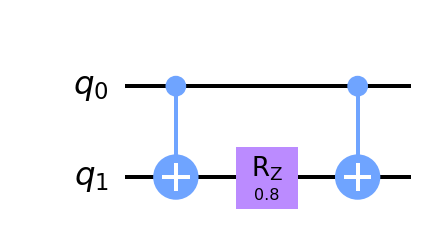

In [2]:
theta = 0.8

qc = QuantumCircuit(2)

qc.cx(0, 1)
qc.rz(theta, 1)
qc.cx(0, 1)

qc.draw('mpl')

### Pulse schedule:

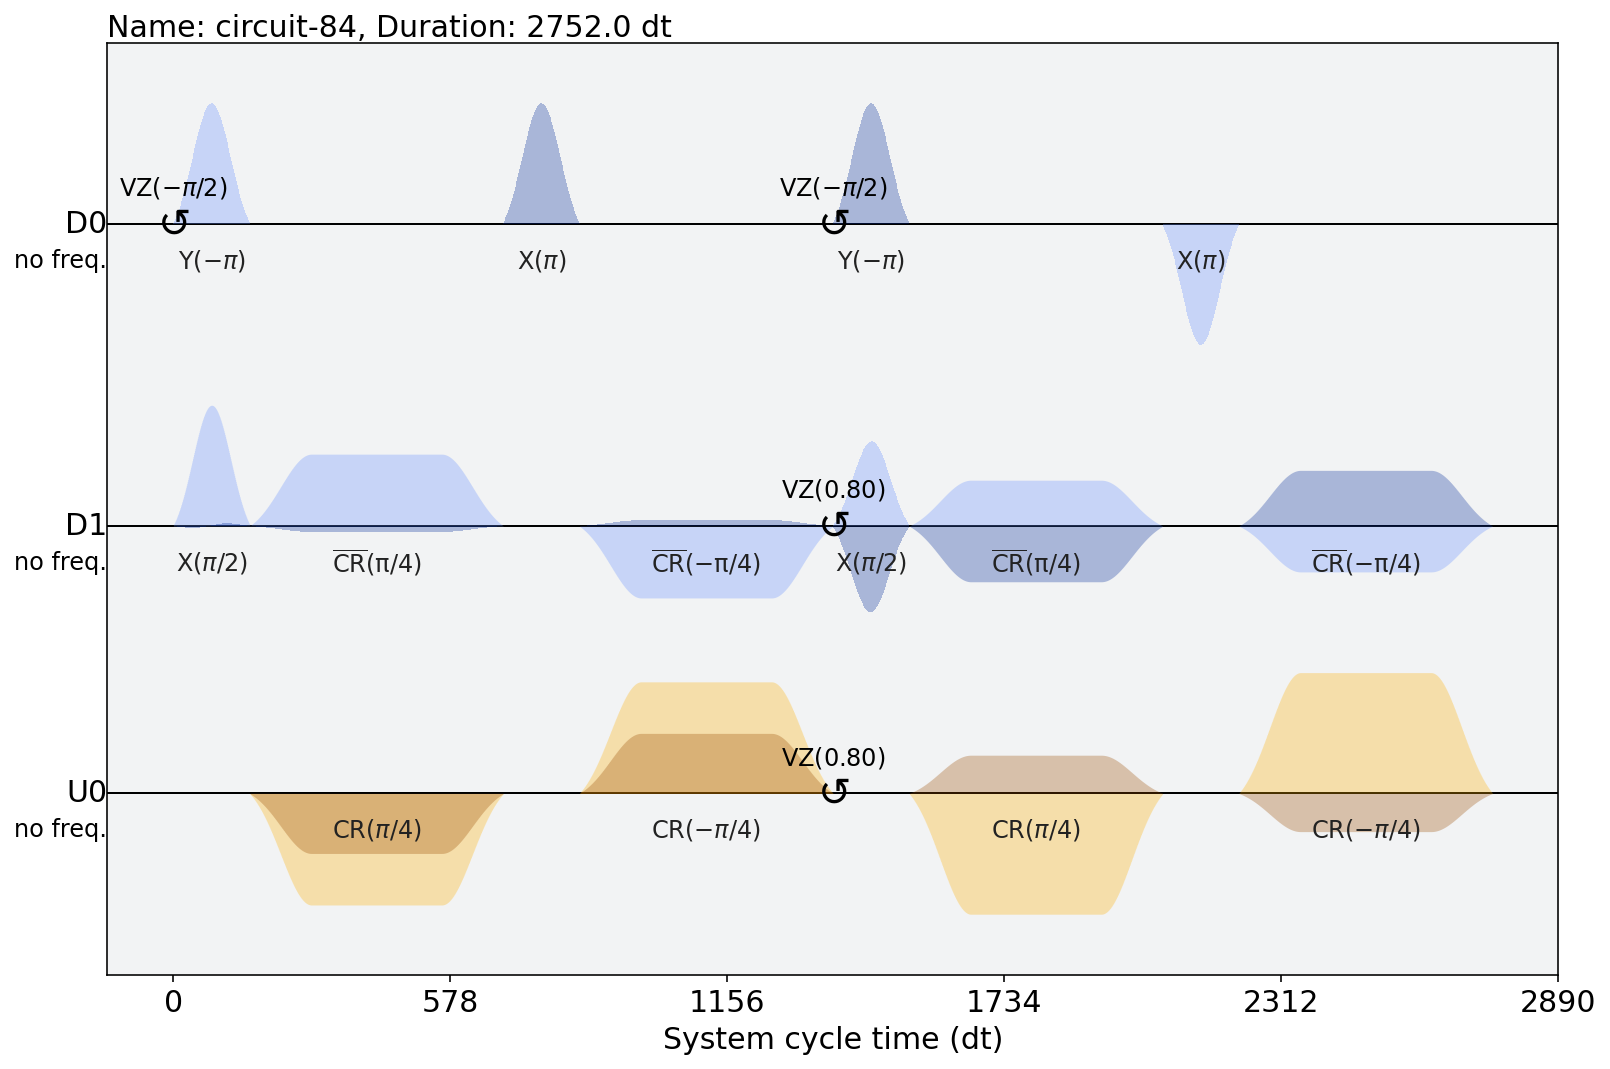

In [3]:
qct = transpile(qc, backend)
schedule(qct, backend).draw()

## Pulse-scaling technique:

* Rewrite circuit in terms of Cross-Resonance gates.
* Depending on the rotation angle either the width or the amplitude of the flat-top Gaussian pulses of the CNOT pulse schedule is scaled.

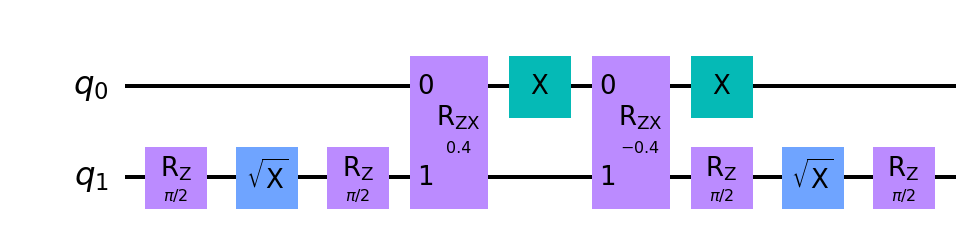

In [4]:
theta = 0.8

# equivalent decomposition in terms of echoed Cross-Resonance gates.

qc = QuantumCircuit(2)

qc.rz(np.pi / 2, 1)
qc.sx(1)
qc.rz(np.pi / 2, 1)
qc.rzx(theta / 2, 0, 1)
qc.x(0)
qc.rzx(-theta / 2, 0, 1)
qc.x(0)
qc.rz(np.pi / 2, 1)
qc.sx(1)
qc.rz(np.pi / 2, 1)

qc.draw('mpl')

### Scale the CNOT pulses and add calibrations with the (already existing) `RZXCalibrationBuilderNoEcho` transpiler pass (see PR [#6300](https://github.com/Qiskit/qiskit-terra/pull/6300)).

In [5]:
# Add the calibrations.
pm = PassManager([RZXCalibrationBuilderNoEcho(backend)])

qc_pulse_efficient = pm.run(qc)

In [6]:
# qc_pulse_efficient.calibrations

### Significant duration reduction!

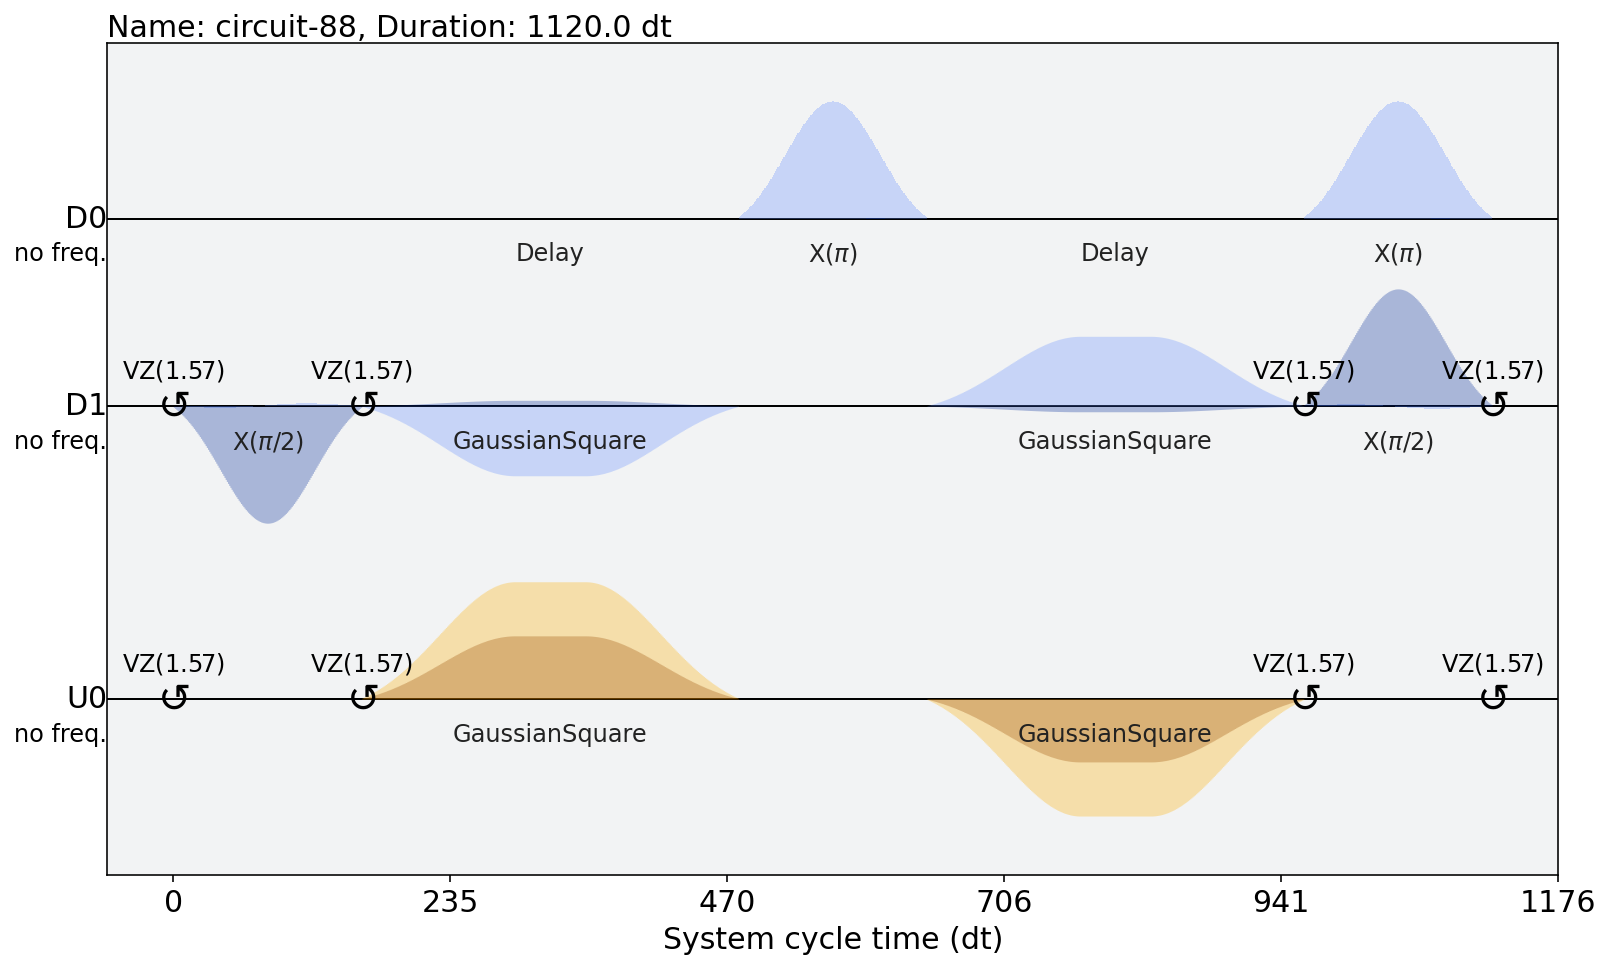

In [7]:
schedule(qc_pulse_efficient, backend).draw()

Compare the durations:

In [8]:
# Compare the schedule durations
print('Duration of standard CNOT-based circuit:')
print(schedule(qct, backend).duration)
print('Duration of pulse-efficient circuit:')
print(schedule(qc_pulse_efficient, backend).duration)

Duration of standard CNOT-based circuit:
2752
Duration of pulse-efficient circuit:
1120


#  <span style='color:darkblue'> 2. Generalization to arbitrary two-qubit gates  </span>

Cartan's Decomposition: Any two-qubit gate can be written in terms of a three-parameter non-local operation and local, single-qubit gates.

![Cartan_Decomposition](images/Cartan_Decomposition.png)

### Equivalent decomposition with three RZX Gates or three CNOT gates:

![RZX_vs_CNOT_Weyl_Decomposition.png](images/RZX_vs_CNOT_Weyl_Decomposition.png)

### Benchmarking results for angles chosen at random in the Weyl chamber [1]:

![WeylChamber_Results_Paper.png](images/WeylChamber_Results_Paper.png)

[1] https://arxiv.org/pdf/2105.01063.pdf

* The pulse scaling technique leads to <span style='color:green'> increased fidelities  </span> for almost all implementations!


* Correlation between relative error reduction and relative duration indicates that we make a better usage of the finite coherence time.

### --> To apply the pulse scaling methodology we need a transpiler pass that rewrites arbitrary quantum circuits               in terms of RZX Gates!

# <span style='color:darkblue'> 3. How we implemented this in Qiskit Terra  (PR [#6784](https://github.com/Qiskit/qiskit-terra/pull/6784))  </span>

### The class ```TwoQubitWeylDecomposition``` computes the three Weyl parameters $\alpha$, $\beta$ and $\gamma$.

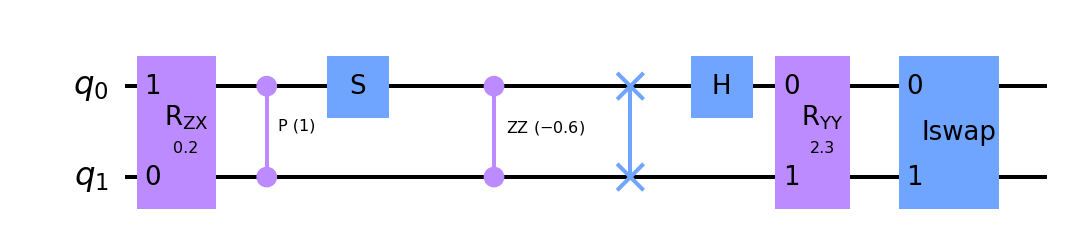

In [9]:
# random two-qubit circuit

qc = QuantumCircuit(2)
qc.rzx(0.2, 1, 0)
qc.cp(1, 0, 1)
qc.s(0)
qc.rzz(-0.6, 0, 1)
qc.swap(0, 1)
qc.h(0)
qc.ryy(2.3, 0, 1)
qc.iswap(0, 1)

qc.draw('mpl')

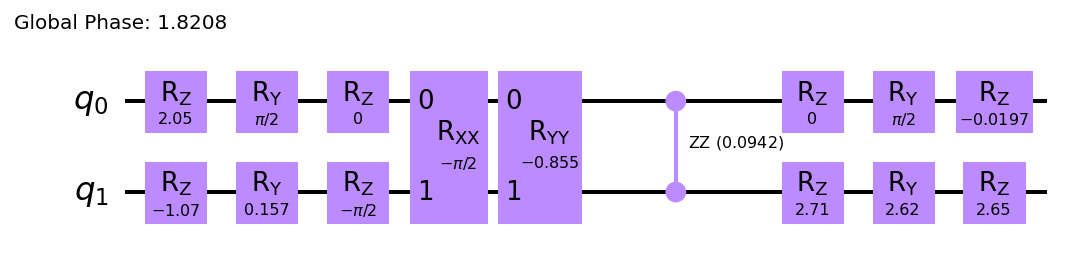

In [10]:
unitary = qi.Operator(qc)

decomposer_weyl = TwoQubitWeylDecomposition(unitary)
decomposer_weyl.circuit().draw('mpl')

##  New: ```TwoQubitControlledUDecomposer```

The ```TwoQubitControlledUDecomposer``` takes a quantum gate (that is locally equivalent to an ```RXXGate```) and computes the Weyl decomposition in terms of this specific gate.

Possible gates: `RXXGate`, `RYYGate`, `RZZGate`, `RZXGate`, `CPhaseGate`, `CRZGate`

### Example:

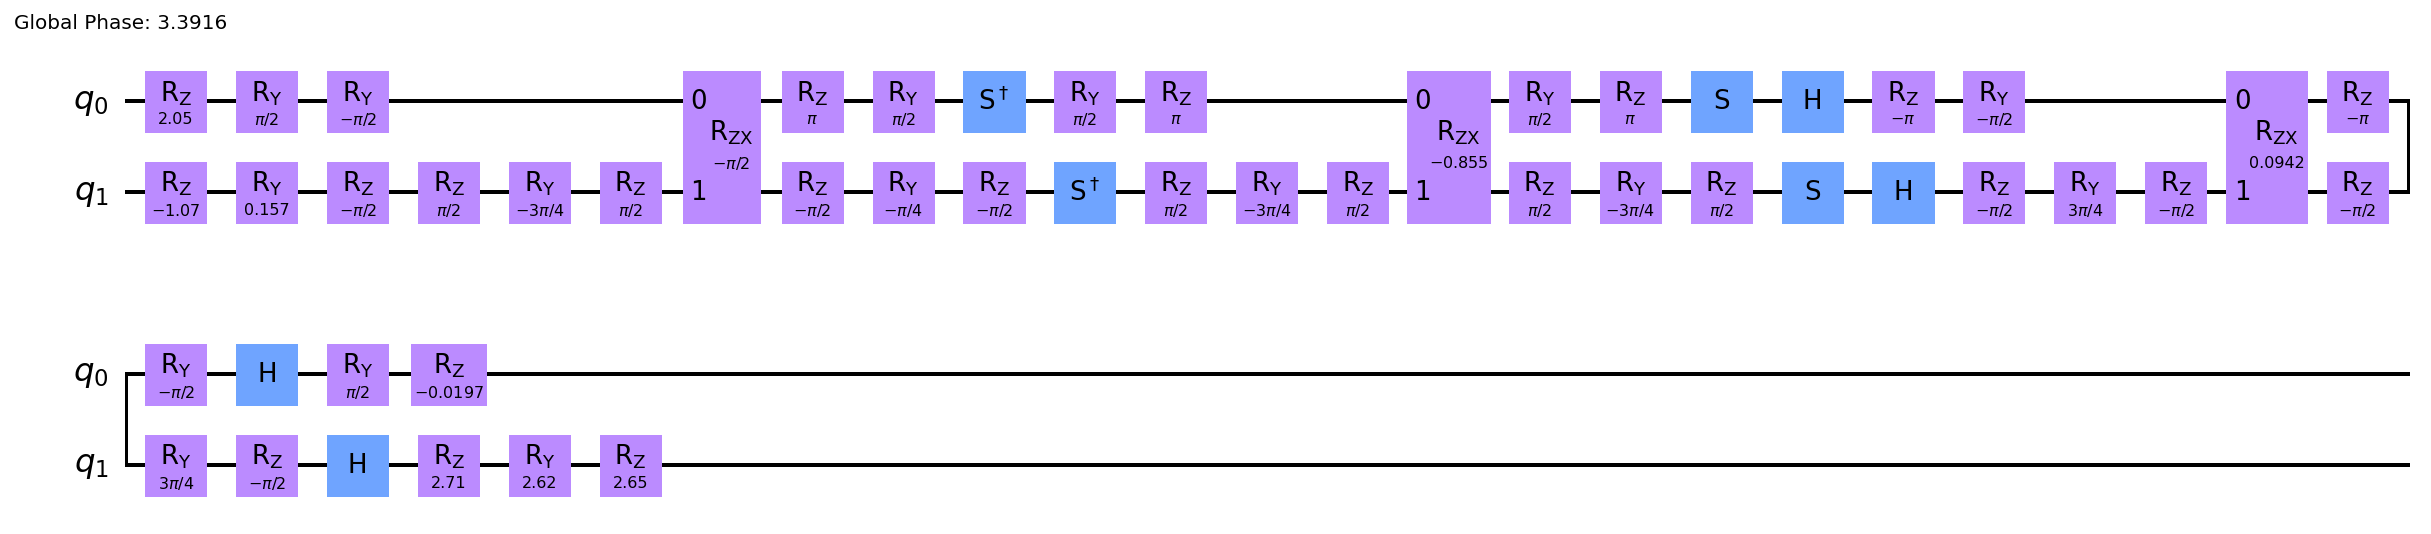

In [11]:
gate = RZXGate

two_qubit_decompose = TwoQubitControlledUDecomposer(gate)
new_circuit = two_qubit_decompose(unitary)

new_circuit.draw('mpl')

### --> Relevant for the pulse-efficient transpiler pass: ```RZXGate``` decomposition.

## ```EchoRZXWeylDecomposition``` transpiler pass implements the ```RZXGate``` decomposition.

* Use ```TwoQubitControlledUDecomposer``` to write all two-qubit gates as RZX gates.
* Check whether the RZX gates have the hardware-native direction and flip and insert Hadamards if not.
* Rewrite RZX($\alpha$) gates as echoed RZX gates, i.e. RZX($\alpha / 2$)-X-RZX($-\alpha /2$)-X

![Echoed_RZX.png](images/Echoed_RZX.png)

# Combine all steps in a Pass Manager:

### <span style= 'background:lightblue'> We can apply the pulse-scaling technique to arbitrary quantum circuits! </span>

Original circuit:


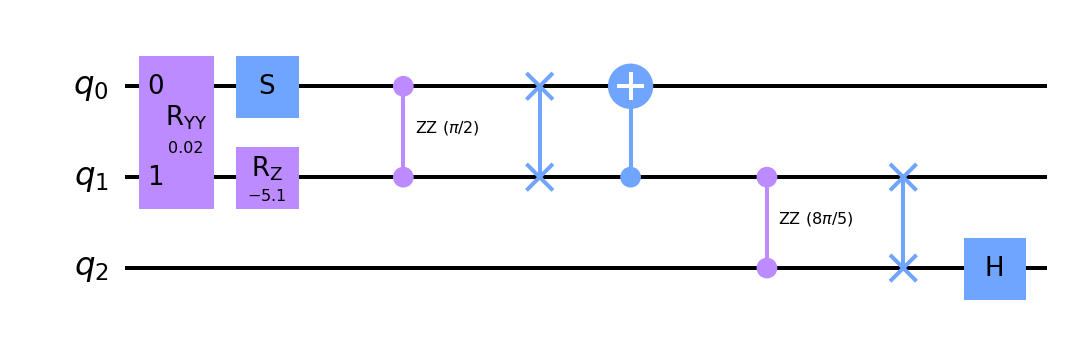

Standard Qiskit transpilation:


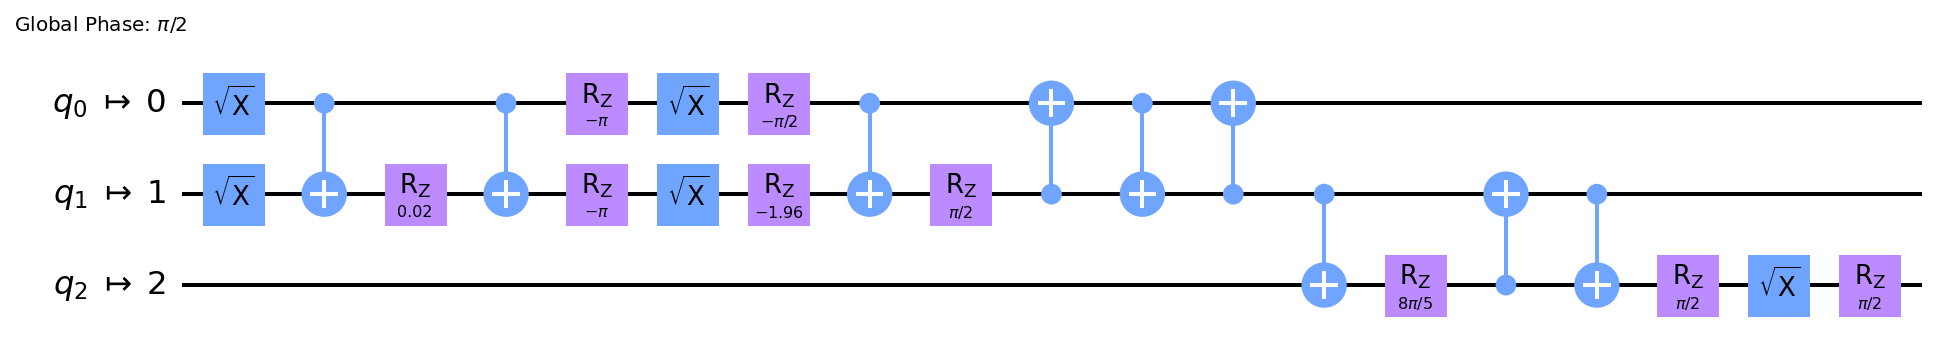

In [12]:
# Random circuit

delta = 8 * np.pi / 5
epsilon = np.pi / 2
eta = -5.1
theta = 0.02

qc = QuantumCircuit(3)
qc.ryy(theta, 0, 1)
qc.s(0)
qc.rz(eta, 1)
qc.rzz(epsilon, 0, 1)
qc.swap(0, 1)
qc.cx(1, 0)
qc.rzz(delta, 1, 2)
qc.swap(1, 2)
qc.h(2)

print('Original circuit:')
display(qc.draw('mpl', idle_wires=False))

qct = transpile(qc, backend)

print('Standard Qiskit transpilation:')
display(qct.draw('mpl', idle_wires=False))

### 1. Consolidate consecutive two-qubit operations

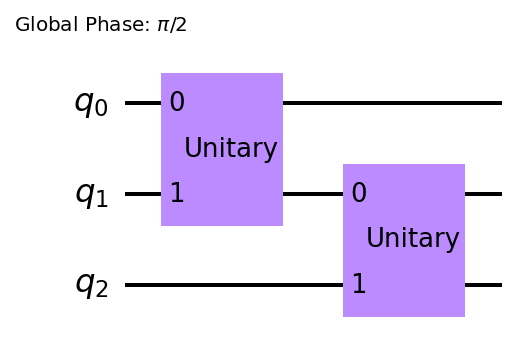

In [13]:
pm = PassManager(
        [
            # Consolidate consecutive two-qubit operations.
            Collect2qBlocks(),
            ConsolidateBlocks(basis_gates=['rz', 'sx', 'x', 'rxx']),
        ]
)
    
qct_consolidated = pm.run(qct)
qct_consolidated.draw('mpl', idle_wires=None)

### 2. Rewrite circuit in terms of Weyl-decomposed echoed RZX gates

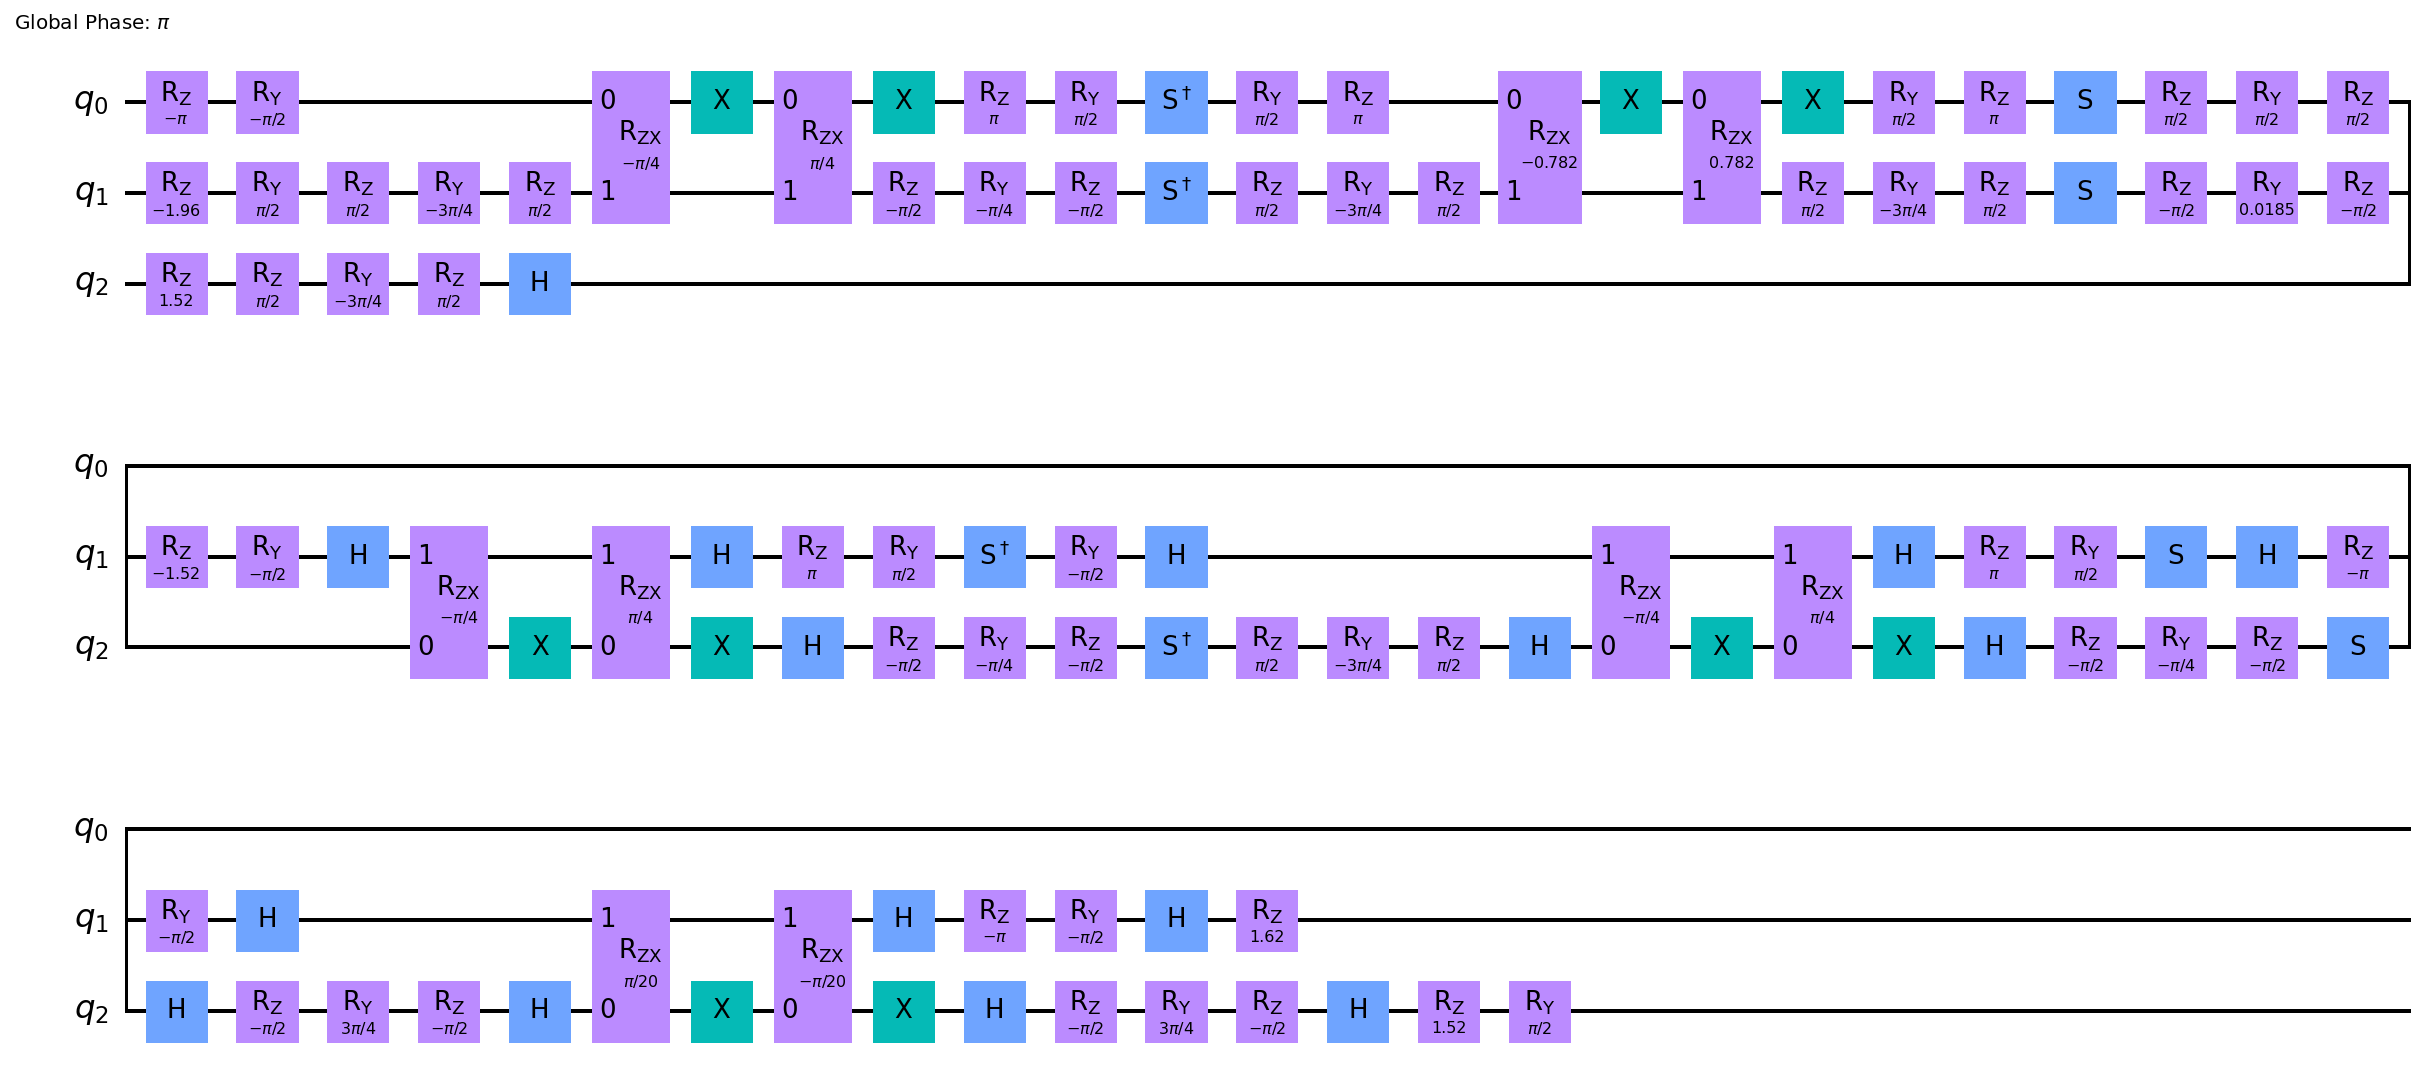

In [14]:
pm = PassManager(
        [
            # Rewrite circuit in terms of Weyl-decomposed echoed RZX gates.
            EchoRZXWeylDecomposition(backend),
        ]
)
    
qct_rzx_weyl = pm.run(qct_consolidated )
qct_rzx_weyl.draw('mpl', idle_wires=None)

### 3. Attach scaled CR pulse schedules to the RZX gates

### 4. Simplify single-qubit gates

## All steps combined:

Original circuit:


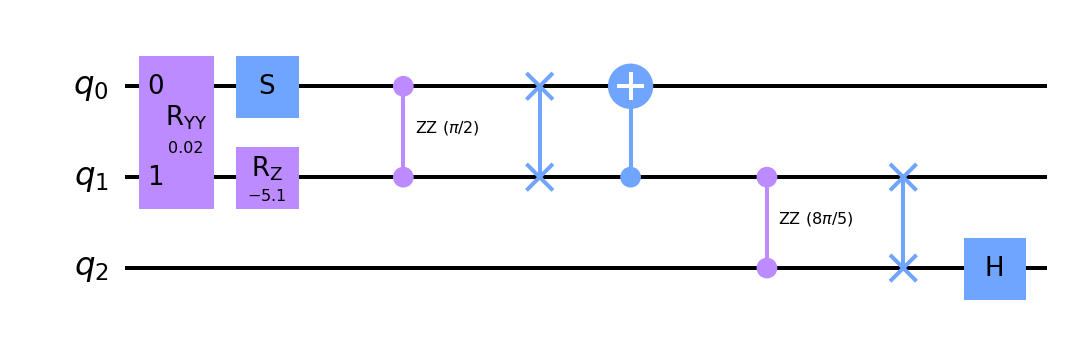

Standard Qiskit transpilation:


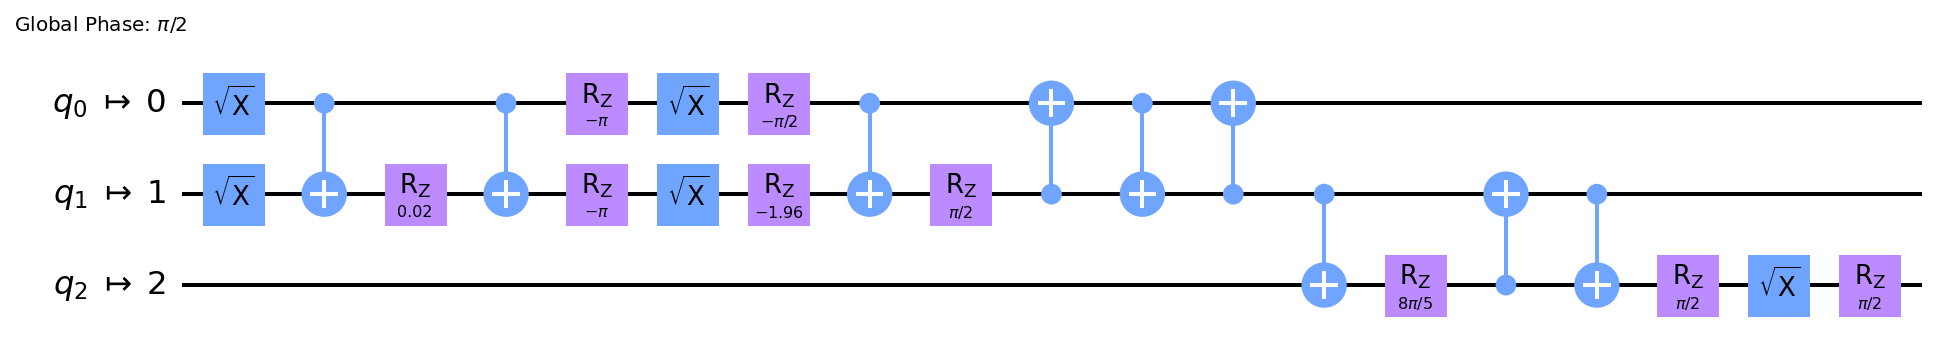

Pulse-efficient, RZX-based circuit:


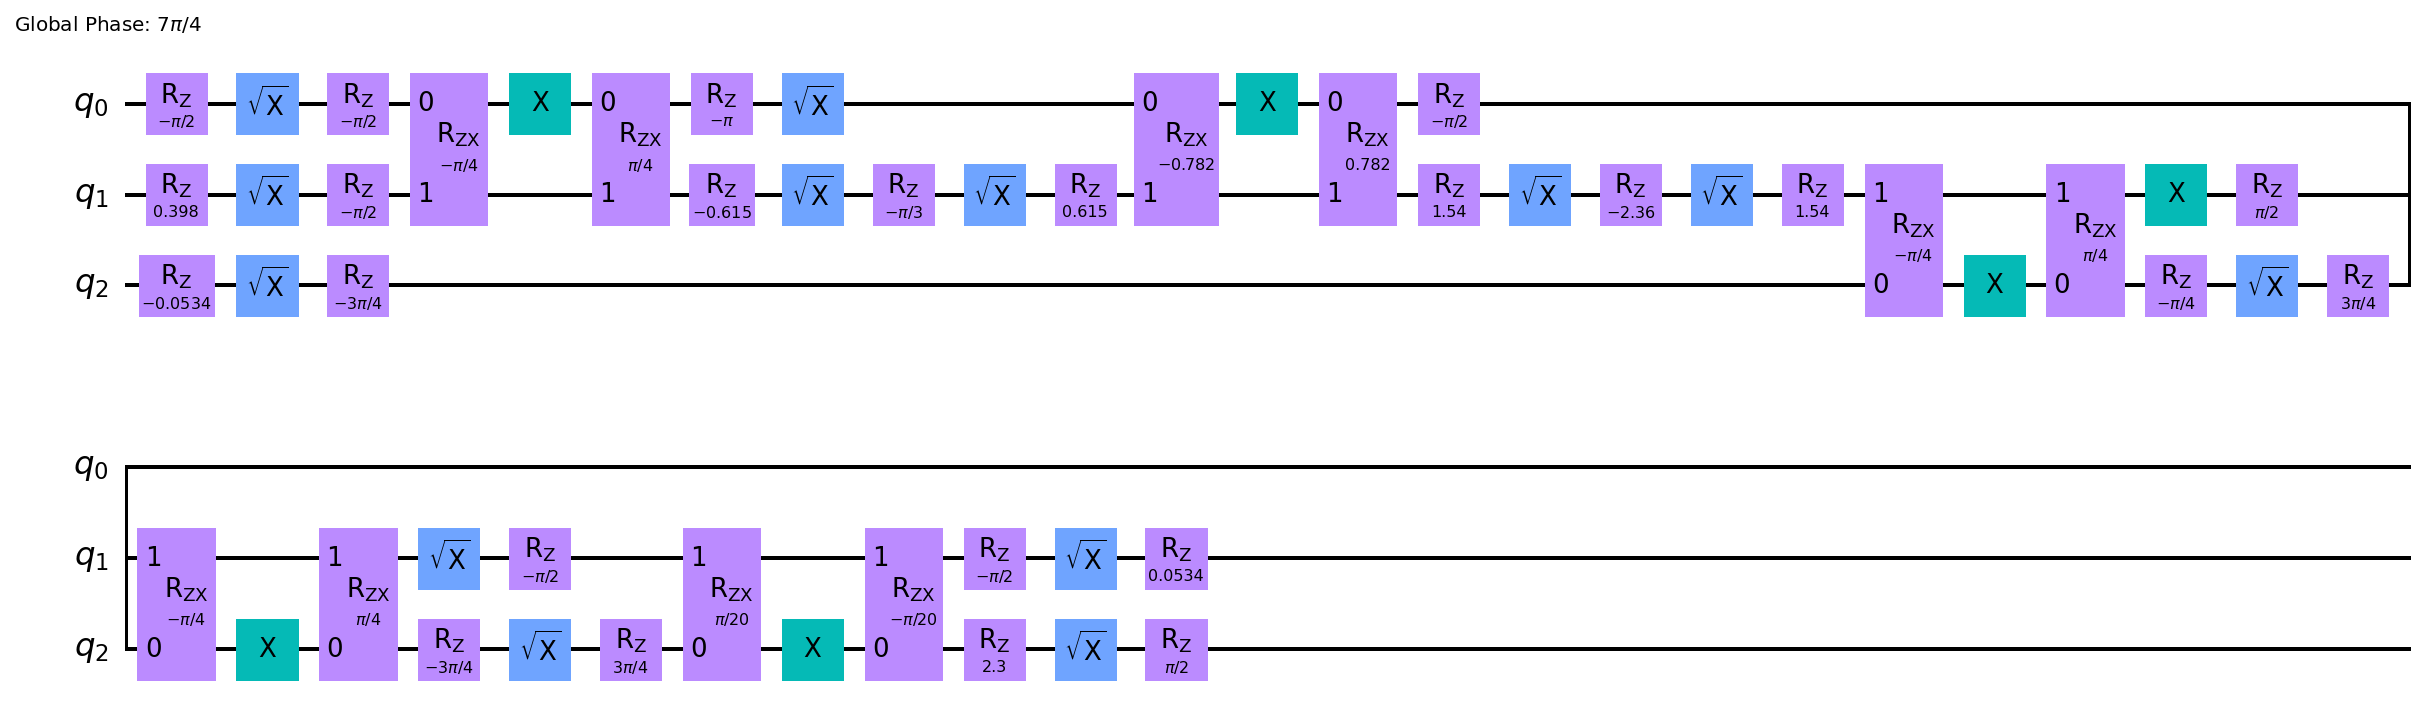

Duration of standard CNOT-based circuit:
13312
Duration of pulse-efficient circuit:
6688


In [15]:
# Random circuit

delta = 8 * np.pi / 5
epsilon = np.pi / 2
eta = -5.1
theta = 0.02

qc = QuantumCircuit(3)
qc.ryy(theta, 0, 1)
qc.s(0)
qc.rz(eta, 1)
qc.rzz(epsilon, 0, 1)
qc.swap(0, 1)
qc.cx(1, 0)
qc.rzz(delta, 1, 2)
qc.swap(1, 2)
qc.h(2)

print('Original circuit:')
display(qc.draw('mpl', idle_wires=False))

qct = transpile(qc, backend)

print('Standard Qiskit transpilation:')
display(qct.draw('mpl', idle_wires=False))

rzx_basis = ['rzx', 'rz', 'x', 'sx']

# Build a pass manager that contains all needed transpiler passes
pm = PassManager(
        [
            # Consolidate consecutive two-qubit operations.
            Collect2qBlocks(),
            ConsolidateBlocks(basis_gates=['rz', 'sx', 'x', 'rxx']),
            
            # Rewrite circuit in terms of Weyl-decomposed echoed RZX gates.
            EchoRZXWeylDecomposition(backend),
            
            # Attach scaled CR pulse schedules to the RZX gates.
            RZXCalibrationBuilderNoEcho(backend),
            
            # Simplify single-qubit gates.
            UnrollCustomDefinitions(std_eqlib, rzx_basis),
            BasisTranslator(std_eqlib, rzx_basis),
            Optimize1qGatesDecomposition(rzx_basis)
        ]
    )
    
# Run the pass manager    
qc_pulse_efficient = pm.run(qct)

print('Pulse-efficient, RZX-based circuit:')
display(qc_pulse_efficient.draw('mpl', idle_wires=False))

# Compare the schedule durations
print('Duration of standard CNOT-based circuit:')
print(schedule(qct, backend).duration)
print('Duration of pulse-efficient circuit:')
print(schedule(qc_pulse_efficient, backend).duration)